In [21]:
from transpile_benchy.interface import QASMBench, RedQueen

qasm_bench_s = QASMBench(size="small")
qasm_bench_m = QASMBench(size="medium")
# redqueen = RedQueen()

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(6, 6)
# coupling_map = CouplingMap.from_grid(3,4)
# coupling_map = CouplingMap.from_heavy_hex(5)

from virtual_swap.pass_managers import SabreVS, SabreQiskit  # , QiskitLevel3

In [22]:
# mqtbench = MQTBench(num_qubits=6)

In [23]:
# # 5Q backend = provider.backend.ibmq_quito
# from qiskit.providers.fake_provider import FakeQuitoV2
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# # # GHZ/BV, QV, EfficientSU2-linear, EfficientSU2-full, Two-local linear, QFT,
# # from qiskit import QuantumCircuit
# # def ghz():
# #     num_qubits = 5
# #     qc = QuantumCircuit(num_qubits, num_qubits, name="ghz")

# #     # Create a GHZ state
# #     qc.h(0)
# #     for i in range(num_qubits - 1):
# #         qc.cx(i, i + 1)
# #     # Insert a barrier before measurement
# #     qc.barrier()
# #     # Measure all of the qubits in the standard basis
# #     for i in range(num_qubits):
# #         qc.measure(i, i)
# #     return qc

# # from qiskit.circuit.library import QuantumVolume
# # def qv():
# #     return QuantumVolume(5, seed=0)

In [24]:
# 5Q backend = provider.backend.ibmq_quito
# 20Q backend = provider.backend.ibmq_mumbai
from typing import Callable, List
from transpile_benchy.interface import QiskitFunctionInterface

num_qubits = [4, 8, 12, 16, 20, 24, 28, 32, 36]
from qiskit.circuit.library import QFT, QuantumVolume

qiskit_functions_qft = QiskitFunctionInterface(QFT, num_qubits)
qiskit_functions_qv = QiskitFunctionInterface(QuantumVolume, num_qubits)

In [25]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
transpile_benchy_logger.setLevel(logging.DEBUG)
# transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        SabreQiskit(coupling_map),  # , cx_basis=True),
        SabreVS(coupling_map, logger=transpile_benchy_logger)  # , cx_basis=True),
        # QiskitLevel3(coupling_map),
    ],
    submodules=[qiskit_functions_qft],
    # submodules=[qasm_bench_m],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
    num_runs=5,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QiskitFunctionInterface:   0%|          | 0/9 [00:00<?, ?it/s]DEBUG:transpile_benchy:Running benchmark for circuit qft_4
DEBUG:transpile_benchy:Running transpiler SabreQiskit on circuit qft_4
DEBUG:transpile_benchy:Calculating Depth for circuit qft_4
INFO:transpile_benchy:Transpiler SabreQiskit, Depth: 18
DEBUG:transpile_benchy:Running transpiler SabreQiskit on circuit qft_4
DEBUG:transpile_benchy:Calculating Depth for circuit qft_4
INFO:transpile_benchy:Transpiler SabreQiskit, Depth: 18
DEBUG:transpile_benchy:Running transpiler SabreQiskit on circuit qft_4
DEBUG:transpile_benchy:Calculating Depth for circuit qft_4
INFO:transpile_benchy:Transpiler SabreQiskit, Depth: 18
DEBUG:transpile_benchy:Running transpiler SabreQiskit on circuit qft_4
DEBUG:transpile_benchy:Calculating Depth for circuit qft_4
INFO:transpile_benchy:Transpiler SabreQiskit, Depth: 18
DEBUG:transpile_benchy:Running transpiler SabreQiskit on 

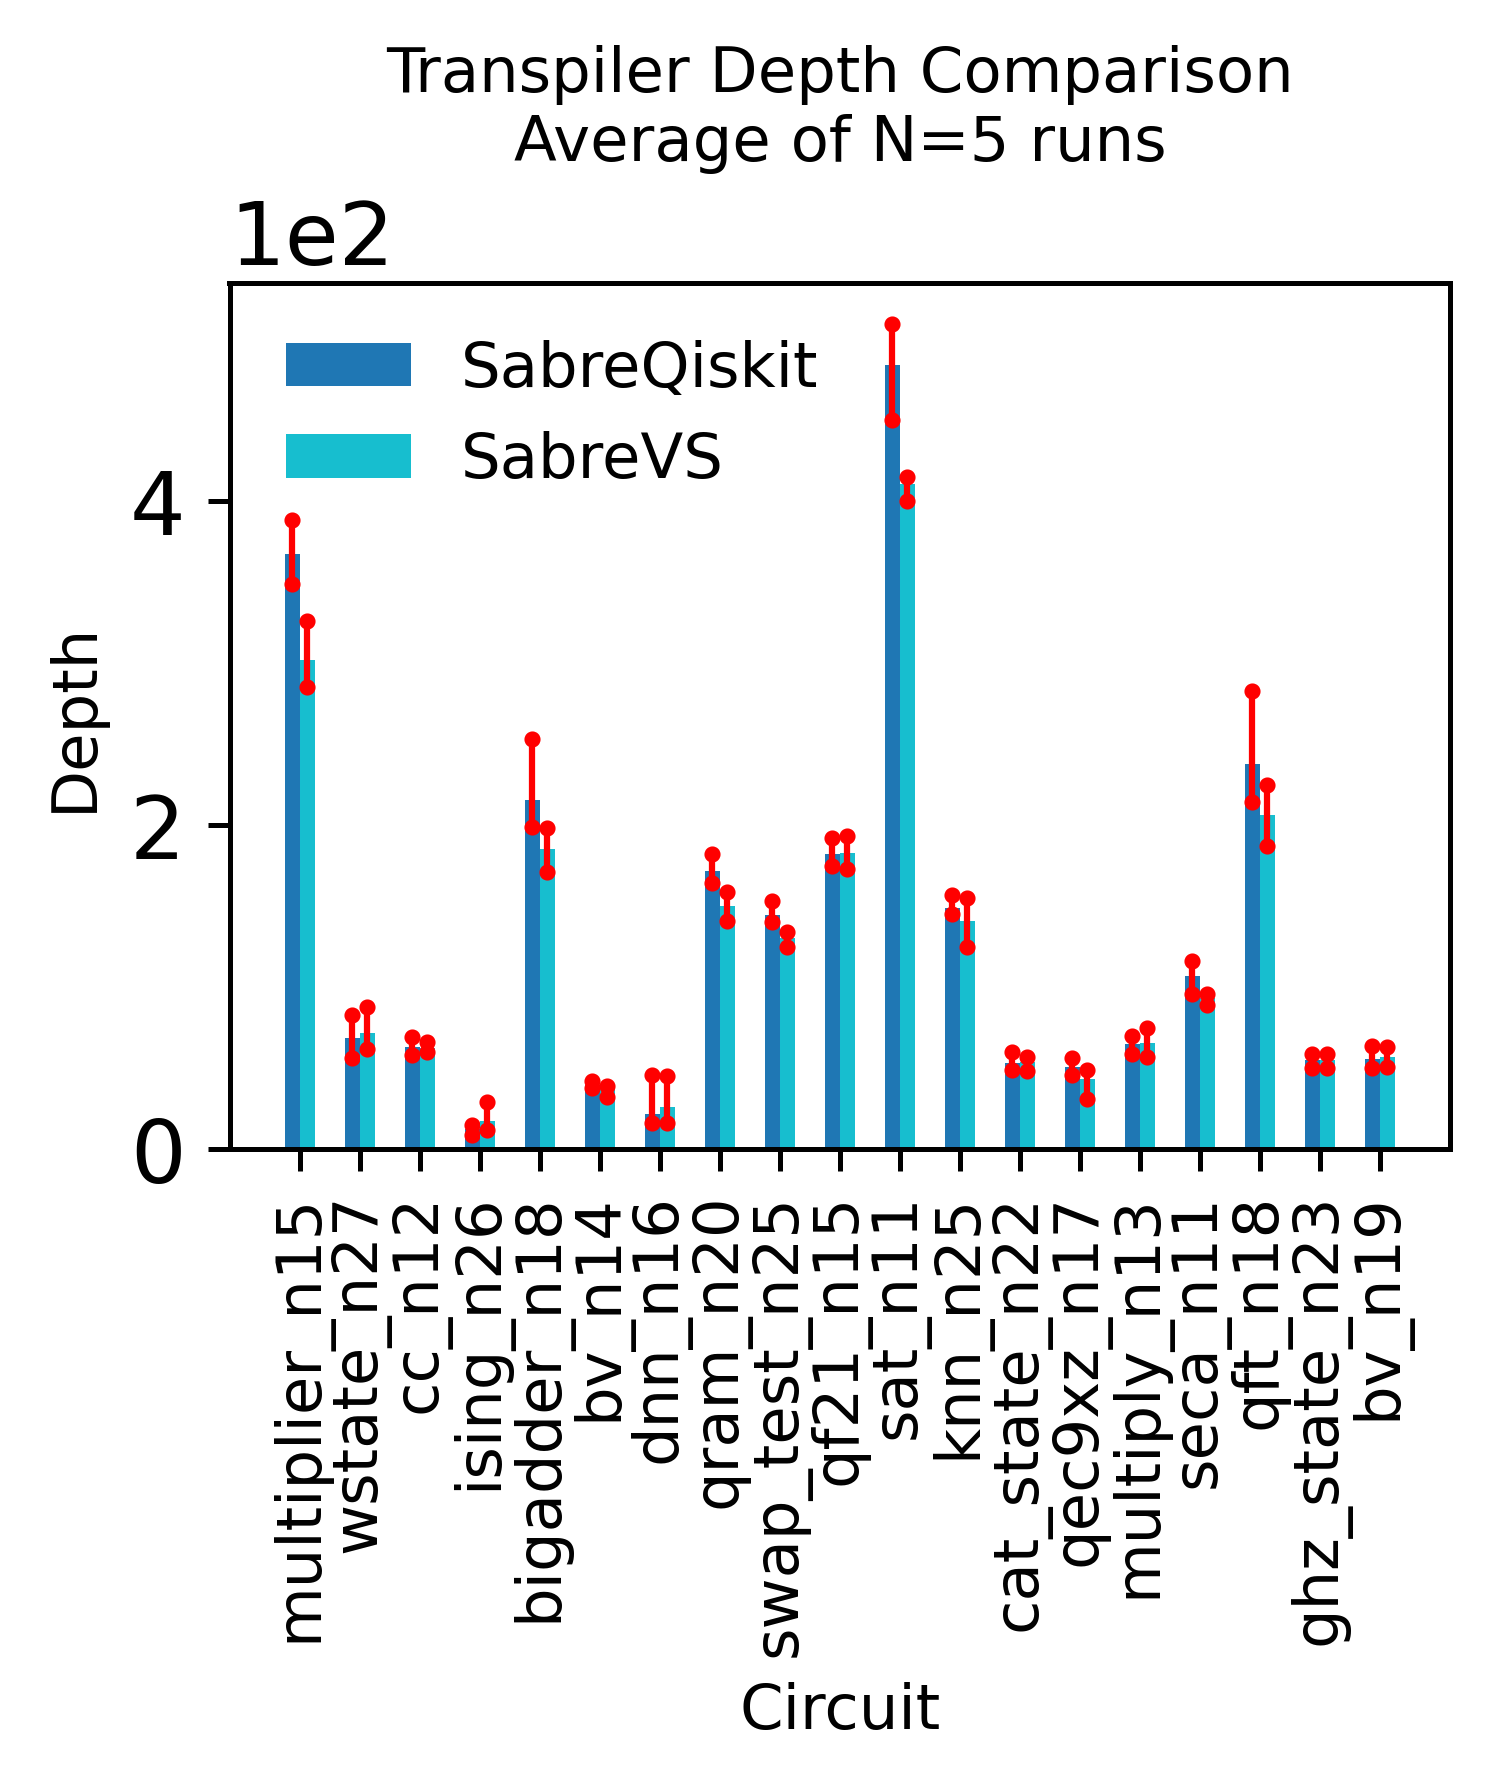

In [ ]:
benchmark.plot()

In [ ]:
print(str(benchmark.results))

Metric: Depth, Circuit: qft_4, Transpiler: SabreQiskit
  Best result: 12
  Worst result: 18
  Average result: 16.40
  Standard error: 2.61
Metric: Depth, Circuit: qft_4, Transpiler: SabreVS
  Best result: 12
  Worst result: 13
  Average result: 12.20
  Standard error: 0.45
Metric: Depth, Circuit: qft_8, Transpiler: SabreQiskit
  Best result: 58
  Worst result: 68
  Average result: 63.00
  Standard error: 4.00
Metric: Depth, Circuit: qft_8, Transpiler: SabreVS
  Best result: 51
  Worst result: 64
  Average result: 56.60
  Standard error: 5.32
Metric: Depth, Circuit: qft_12, Transpiler: SabreQiskit
  Best result: 112
  Worst result: 135
  Average result: 125.60
  Standard error: 8.96
Metric: Depth, Circuit: qft_12, Transpiler: SabreVS
  Best result: 96
  Worst result: 127
  Average result: 111.20
  Standard error: 11.78


In [ ]:
print(str(benchmark.results))

Metric: Depth, Circuit: multiplier_n15, Transpiler: SabreQiskit
  Best result: 349
  Worst result: 388
  Average result: 367.00
  Standard error: 16.43
Metric: Depth, Circuit: multiplier_n15, Transpiler: SabreVS
  Best result: 285
  Worst result: 326
  Average result: 301.60
  Standard error: 16.20
Metric: Depth, Circuit: wstate_n27, Transpiler: SabreQiskit
  Best result: 56
  Worst result: 83
  Average result: 68.40
  Standard error: 10.99
Metric: Depth, Circuit: wstate_n27, Transpiler: SabreVS
  Best result: 62
  Worst result: 88
  Average result: 71.80
  Standard error: 10.40
Metric: Depth, Circuit: cc_n12, Transpiler: SabreQiskit
  Best result: 58
  Worst result: 69
  Average result: 63.00
  Standard error: 4.06
Metric: Depth, Circuit: cc_n12, Transpiler: SabreVS
  Best result: 60
  Worst result: 66
  Average result: 62.20
  Standard error: 2.39
Metric: Depth, Circuit: ising_n26, Transpiler: SabreQiskit
  Best result: 9
  Worst result: 15
  Average result: 12.60
  Standard error: 2

### Below used for debugging indivudal circuit runs


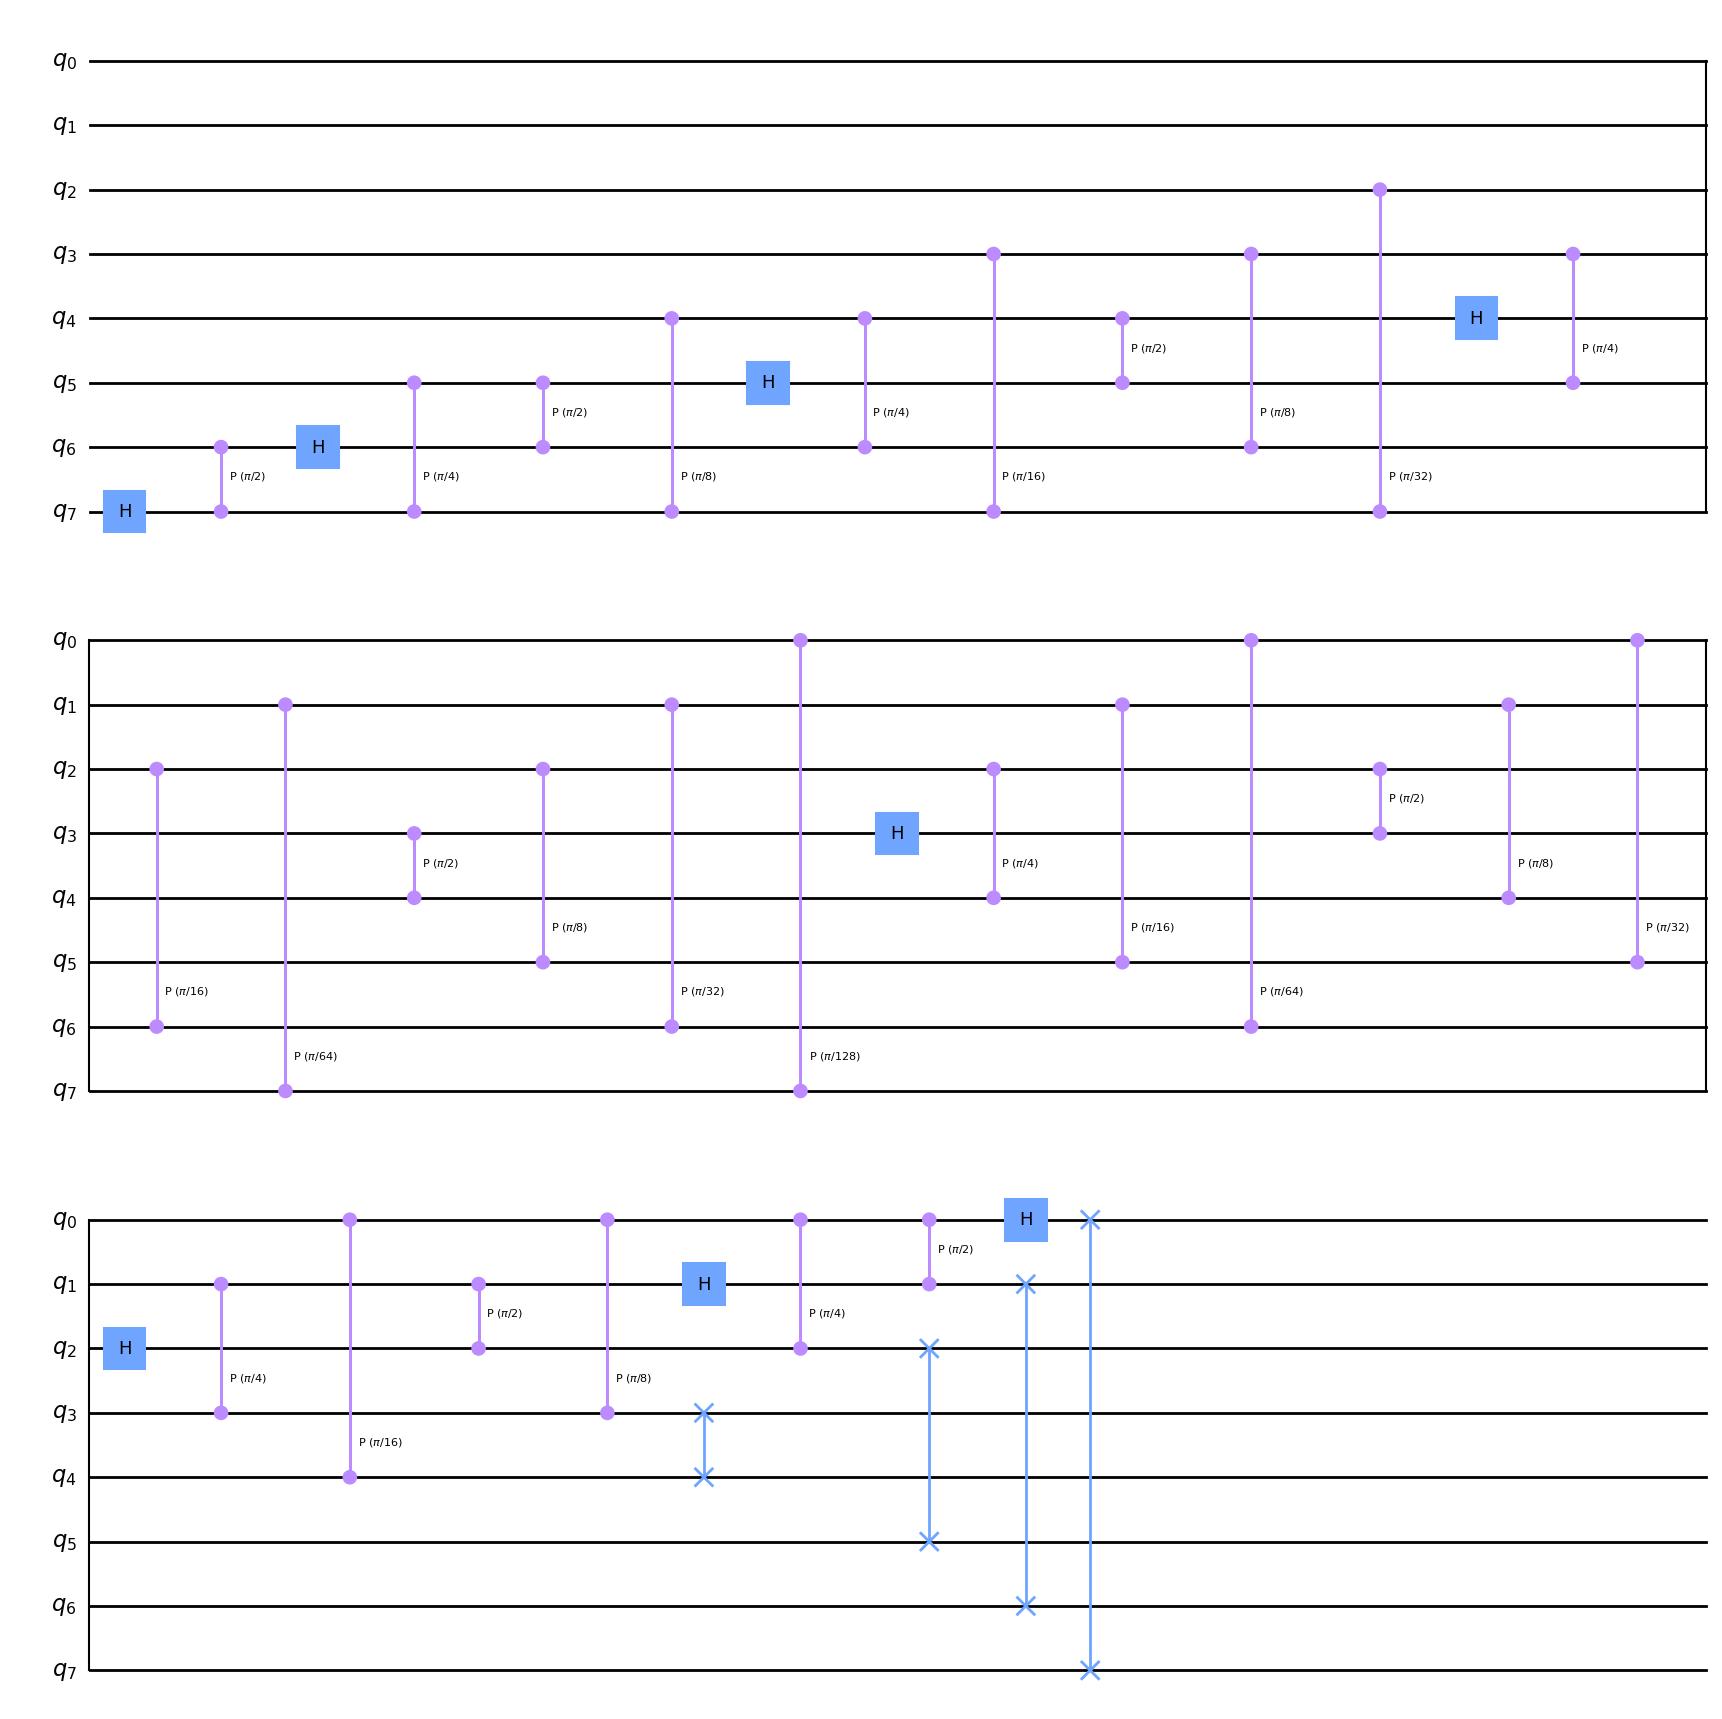

In [ ]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit

# qc = EfficientSU2(5, entanglement="full")
qc = QFT(8)
# from qiskit import QuantumCircuit
# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
qc.decompose().draw("mpl")

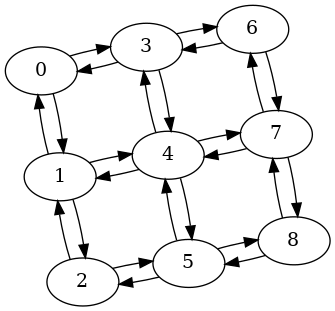

In [ ]:
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap

coupling_map = FakeQuitoV2().target.build_coupling_map()
coupling_map = CouplingMap.from_line(4)
coupling_map = CouplingMap.from_grid(3, 3)
coupling_map.draw()

In [ ]:
# from qiskit.circuit.library import QFT

# # coupling_map = CouplingMap.from_line(5)
# coupling_map = CouplingMap.from_grid(5, 6)
# # qc = QFT(8)
# # qc = QuantumCircuit(8)
# # qc.h(0)
# # qc.cx(0, 1)
# # qc.cx(1, 2)
# # qc.cx(2, 3)
# # # qc.cx(3, 4)
# # qc.cx(4, 5)
# # qc.cx(5, 6)
# # qc.cx(6, 7)
# qc.decompose().draw(output="mpl")

62
48
55
53
62


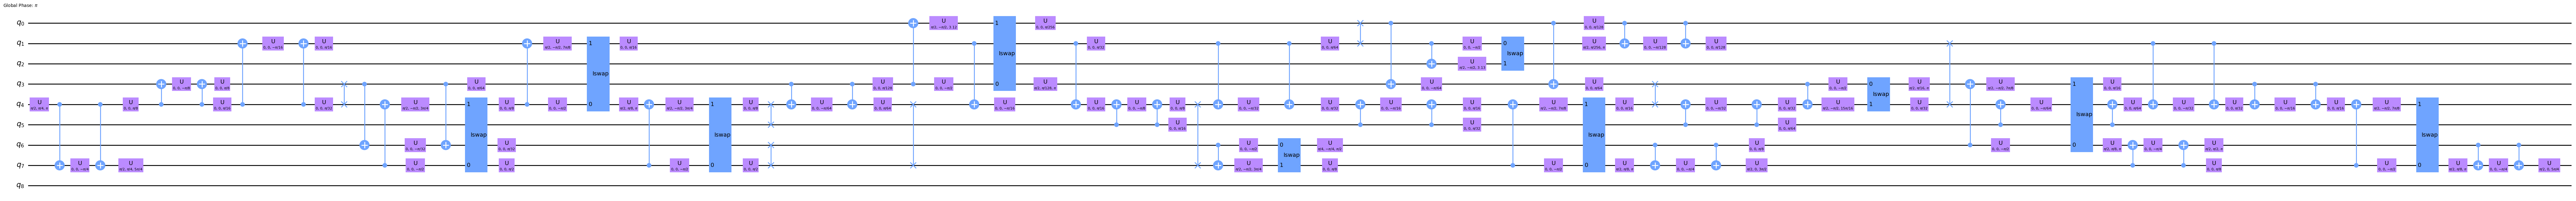

In [ ]:
from virtual_swap.pass_managers import SabreVS, SabreQiskit
from transpile_benchy.metrics import DepthMetric

for _ in range(5):
    runner = SabreVS(coupling_map)  # , cx_basis=True)
    transp = runner.run(qc)
    # mid0 = runner.pm.property_set["mid0"]
    mid = runner.pm.property_set["circuit_progress"]
    print(DepthMetric.calculate(transp))
mid.draw(output="mpl", fold=-1, filename="qft_vs.svg")
# transp.draw(output="mpl")

In [ ]:
# runner.pm.property_set["layout"]

59
60
56
62
64


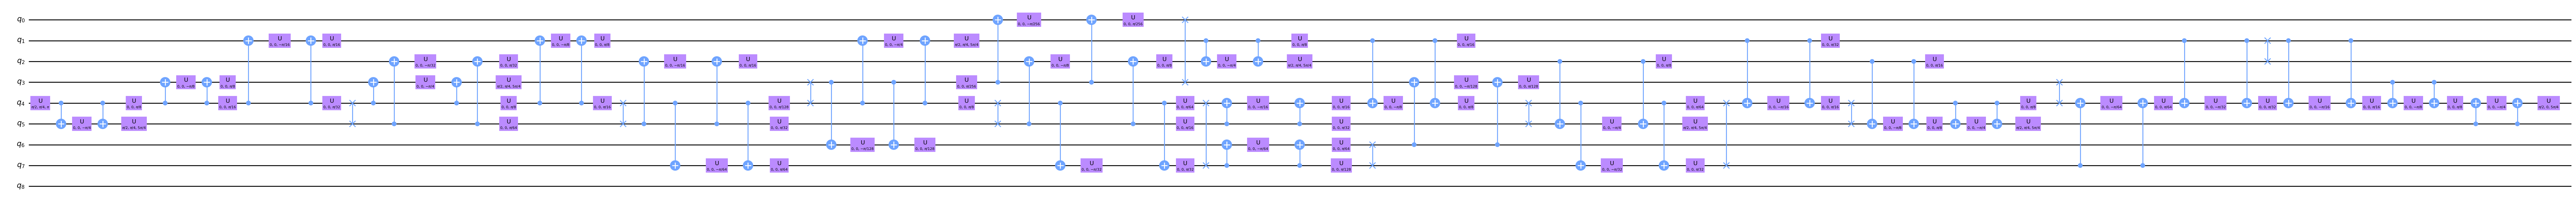

In [ ]:
# set original qc to use
from qiskit import transpile

# qc2 = transpile(qc, initial_layout=runner.pm.property_set["layout"], coupling_map=coupling_map)
# qc2 = transpile(qc, coupling_map=coupling_map, optimization_level=3)
for _ in range(5):
    pm2 = SabreQiskit(coupling_map)  # , cx_basis=True)
    qc2 = pm2.run(qc)
    mid = pm2.pm.property_set["circuit_progress"]
    print(DepthMetric.calculate(qc2))
mid.draw(output="mpl", fold=-1, filename="qft_qiskit.svg")

In [ ]:
# qc2.draw(output="mpl")

In [ ]:
# from qiskit.quantum_info import Operator
# Operator(mid).equiv(qc2)